In [1]:
from fastai.vision.all import *
from models.GAN import Generator, Critic, GANLearner
from fastai.vision.gan import generate_noise
from torchsummary import summary
from util.util import GANImageBlock

In [2]:
path = untar_data(URLs.CIFAR)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('train'),Path('test'),Path('labels.txt')]

In [5]:
train_path = path/'train'/'horse'

In [6]:
train_data = get_image_files(train_path)

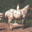

In [7]:
Image.open(train_data[0])

In [8]:
generator = Generator(z_dim=100,
                      unflattened_shape=[128, 4, 4],
                      upsample_scale=[2, 2, 2, 1],
                      filters=[128, 64, 32, 3],
                      kernels=[5, 5, 5, 5],
                      strides=[1, 1, 1, 1],
                      batch_norm_mom=0.8,
                      dropout_prob=None
                     )

In [9]:
summary(generator, (100,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─Linear: 2-1                       [-1, 2048]                206,848
|    └─BatchNorm1d: 2-2                  [-1, 2048]                4,096
|    └─LeakyReLU: 2-3                    [-1, 2048]                --
|    └─Unflatten: 2-4                    [-1, 128, 4, 4]           --
|    └─Upsample: 2-5                     [-1, 128, 8, 8]           --
|    └─Conv2d: 2-6                       [-1, 128, 8, 8]           409,728
|    └─BatchNorm2d: 2-7                  [-1, 128, 8, 8]           256
|    └─LeakyReLU: 2-8                    [-1, 128, 8, 8]           --
|    └─Upsample: 2-9                     [-1, 128, 16, 16]         --
|    └─Conv2d: 2-10                      [-1, 64, 16, 16]          204,864
|    └─BatchNorm2d: 2-11                 [-1, 64, 16, 16]          128
|    └─LeakyReLU: 2-12                   [-1, 64, 16, 16]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─Linear: 2-1                       [-1, 2048]                206,848
|    └─BatchNorm1d: 2-2                  [-1, 2048]                4,096
|    └─LeakyReLU: 2-3                    [-1, 2048]                --
|    └─Unflatten: 2-4                    [-1, 128, 4, 4]           --
|    └─Upsample: 2-5                     [-1, 128, 8, 8]           --
|    └─Conv2d: 2-6                       [-1, 128, 8, 8]           409,728
|    └─BatchNorm2d: 2-7                  [-1, 128, 8, 8]           256
|    └─LeakyReLU: 2-8                    [-1, 128, 8, 8]           --
|    └─Upsample: 2-9                     [-1, 128, 16, 16]         --
|    └─Conv2d: 2-10                      [-1, 64, 16, 16]          204,864
|    └─BatchNorm2d: 2-11                 [-1, 64, 16, 16]          128
|    └─LeakyReLU: 2-12                   [-1, 64, 16, 16]        

In [10]:
critic = Critic(input_shape=[3, 32, 32],
                filters=[32, 64, 128, 128],
                kernels=[5, 5, 5, 5],
                strides=[2, 2, 2, 1],
                batch_norm_mom=None,
                dropout_prob=None
               )

In [11]:
summary(critic, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 32, 16, 16]          2,432
|    └─LeakyReLU: 2-2                    [-1, 32, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 64, 8, 8]            51,264
|    └─LeakyReLU: 2-4                    [-1, 64, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 128, 4, 4]           204,928
|    └─LeakyReLU: 2-6                    [-1, 128, 4, 4]           --
|    └─Conv2d: 2-7                       [-1, 128, 4, 4]           409,728
|    └─LeakyReLU: 2-8                    [-1, 128, 4, 4]           --
|    └─Flatten: 2-9                      [-1, 2048]                --
|    └─Linear: 2-10                      [-1, 1]                   2,049
Total params: 670,401
Trainable params: 670,401
Non-trainable params: 0
Total mult-adds (M): 14.39
Input size (MB): 0.01
Forward/backwa

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 32, 16, 16]          2,432
|    └─LeakyReLU: 2-2                    [-1, 32, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 64, 8, 8]            51,264
|    └─LeakyReLU: 2-4                    [-1, 64, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 128, 4, 4]           204,928
|    └─LeakyReLU: 2-6                    [-1, 128, 4, 4]           --
|    └─Conv2d: 2-7                       [-1, 128, 4, 4]           409,728
|    └─LeakyReLU: 2-8                    [-1, 128, 4, 4]           --
|    └─Flatten: 2-9                      [-1, 2048]                --
|    └─Linear: 2-10                      [-1, 1]                   2,049
Total params: 670,401
Trainable params: 670,401
Non-trainable params: 0
Total mult-adds (M): 14.39
Input size (MB): 0.01
Forward/backwa

In [13]:
datablock = DataBlock(blocks=(TransformBlock, GANImageBlock),
                      get_items=get_image_files,
                      get_x=generate_noise,
                      splitter = RandomSplitter(seed=42)
                     )

In [14]:
dataloaders = datablock.dataloaders(train_path)

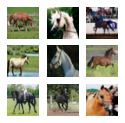

In [15]:
dataloaders.show_batch(max_n=9, figsize=(2, 2))

In [16]:
learner = GANLearner.wgan(dataloaders=dataloaders,
                          generator=generator,
                          critic=critic,
                          opt_func=RMSProp
                         )

# Since the validation loss is the same as the generator loss, don't display it
learner.recorder.train_metrics = True
learner.recorder.valid_metrics = False

In [ ]:
learner.fit(1000, 5e-5)

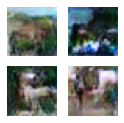

In [18]:
# Results after running learner.fit. I cleared the output from that cell for space reasons. Likely need to run for
# many more epochs for generated images that look more like horses.

learner.show_results(max_n=4, ds_idx=0, figsize=(2, 2))